In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
path = "/Users/hongjonghyeok/Downloads/데이터 전처리 과정/최종통합본.csv"
df = pd.read_csv(path)

In [4]:
df.columns

Index(['Name', 'Address', 'Latitude', 'Longitude', 'Supply_type',
       'Applicant_type', 'Units', 'Gender', 'Shared', 'Cutline_rate',
       'Cutline_score', 'Year', 'Quarter', 'Applied_type', 'Counts_daiso',
       'Counts_supermarket', 'Counts_laundry', 'Counts_pharmacy',
       'Counts_cafe', 'Counts_convstore', 'Counts_station', 'Infra_score',
       'people', 'Rate1', 'Rate2', 'Rate3'],
      dtype='object')

In [5]:
df.dropna(axis=0, inplace=True)

In [25]:
# 주요 입력 변수 및 타겟 변수 선택
features = ['Supply_type', 'Units', 'Year',
            'Rate1', 'Rate2', 'Rate3', 'Applicant_type',
           'Applied_type', 'Cutline_score']
X = df[features]
y = df['Cutline_rate']  # 분류 타겟

In [26]:
X.shape

(876, 9)

In [27]:
# 범주형 변수 인코딩
X['Supply_type'] = LabelEncoder().fit_transform(X['Supply_type'])
X['Applicant_type'] = LabelEncoder().fit_transform(X['Applicant_type'])
#X['Gender'] = LabelEncoder().fit_transform(X['Gender'])
X['Applied_type'] = LabelEncoder().fit_transform(X['Applied_type'])
#X['Shared'] = LabelEncoder().fit_transform(X['Shared'])
X['Year'] = LabelEncoder().fit_transform(X['Year'])
#X['Quarter'] = LabelEncoder().fit_transform(X['Quarter'])

/var/folders/4g/1y1rn_456xx_f85fqpq2pl0m0000gn/T/ipykernel_3378/999961147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Supply_type'] = LabelEncoder().fit_transform(X['Supply_type'])
/var/folders/4g/1y1rn_456xx_f85fqpq2pl0m0000gn/T/ipykernel_3378/999961147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Applicant_type'] = LabelEncoder().fit_transform(X['Applicant_type'])
/var/folders/4g/1y1rn_456xx_f85fqpq2pl0m0000gn/T/ipykernel_3378/999961147.py:5: SettingWithCopyWarning: 
A value is trying

In [28]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# ADASYN 적용
adasyn = ADASYN(random_state=42)
X_s, y_s = adasyn.fit_resample(X, y)

# 결과 확인
print("오버샘플링 전 클래스 분포:", Counter(y))
print("오버샘플링 후 클래스 분포:", Counter(y_s))

오버샘플링 전 클래스 분포: Counter({1: 573, 2: 269, 3: 34})
오버샘플링 후 클래스 분포: Counter({3: 576, 1: 573, 2: 529})


In [29]:
X = X_s.copy()
X = X.drop(columns='Cutline_score')
y_classification = y_s.copy()  # 분류 타겟
y_regression = X_s['Cutline_score']    # 회귀 타겟

In [30]:
X.columns

Index(['Supply_type', 'Units', 'Year', 'Rate1', 'Rate2', 'Rate3',
       'Applicant_type', 'Applied_type'],
      dtype='object')

In [31]:
# 데이터 분리
X_train, X_test, y_train_classification, y_test_classification, y_train_regression, y_test_regression = train_test_split(X, y_classification, y_regression, test_size=0.1, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
# 레이블 값 변환 (1 → 0, 2 → 1, 3 → 2)
y_train_classification = y_train_classification - 1
y_test_classification = y_test_classification - 1

In [34]:
X_train.shape

(1510, 8)

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 입력 레이어
il = Input(shape=(X_train.shape[1],))

# 공유 레이어
dl = Dense(512, activation='relu')(il)
dl = Dense(256, activation='relu')(dl)
dl = Dense(256, activation='relu')(dl)
dl = Dense(128, activation='relu')(dl)


# 분류 헤드 (cutline_rate)
classification_head = Dense(3, activation='softmax', name='classification')(dl)

# 회귀 헤드 (cutline_score)
regression_head = Dense(1, activation='relu', name='regression')(dl)

In [46]:
# 모델 정의
model = Model(inputs=il, outputs=[classification_head, regression_head])

In [47]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss={'classification': 'sparse_categorical_crossentropy', 'regression': 'mse'},
    metrics={'classification': 'accuracy', 'regression': 'mae'})

In [48]:
# EarlyStopping 콜백 정의
es = EarlyStopping(
    monitor='val_loss',       # 검증 손실을 모니터링
    patience=15,              # 개선되지 않는 에포크를 15번 허용
    restore_best_weights=True) # 가장 좋은 가중치를 복원

In [49]:
checkpoint_path = 'best_model.keras'
mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

In [50]:
# 모델 학습
history = model.fit(
    X_train,
    {'classification': y_train_classification, 'regression': y_train_regression},
    validation_data=(X_test, {'classification': y_test_classification, 'regression': y_test_regression}),
    epochs=100,               # 최대 에포크 수
    batch_size=1,
    callbacks=[es, mc]) # EarlyStopping 콜백 추가

Epoch 1/100
1472/1510 [============================>.] - ETA: 0s - loss: 5.8365 - classification_loss: 0.8188 - regression_loss: 5.0177 - classification_accuracy: 0.6033 - regression_mae: 1.6215
Epoch 1: val_loss improved from inf to 5.26665, saving model to best_model.keras
1510/1510 [==============================] - 2s 959us/step - loss: 5.8179 - classification_loss: 0.8166 - regression_loss: 5.0013 - classification_accuracy: 0.6060 - regression_mae: 1.6179 - val_loss: 5.2667 - val_classification_loss: 0.7529 - val_regression_loss: 4.5137 - val_classification_accuracy: 0.6071 - val_regression_mae: 1.4891
Epoch 2/100
1472/1510 [============================>.] - ETA: 0s - loss: 4.6463 - classification_loss: 0.6639 - regression_loss: 3.9823 - classification_accuracy: 0.7038 - regression_mae: 1.4385
Epoch 2: val_loss improved from 5.26665 to 4.40111, saving model to best_model.keras
1510/1510 [==============================] - 1s 863us/step - loss: 4.5786 - classification_loss: 0.6599 -

In [51]:
# 테스트 데이터 평가
from sklearn.metrics import confusion_matrix
results = model.evaluate(
    X_test,
    {'classification': y_test_classification, 'regression': y_test_regression})

print(f"Classification Accuracy: {results[3]}")
print(f"Regression MAE: {results[4]}")

6/6 [==============================] - 0s 952us/step - loss: 2.6479 - classification_loss: 0.3471 - regression_loss: 2.3009 - classification_accuracy: 0.8512 - regression_mae: 1.0077
Classification Accuracy: 0.851190447807312
Regression MAE: 1.007728934288025


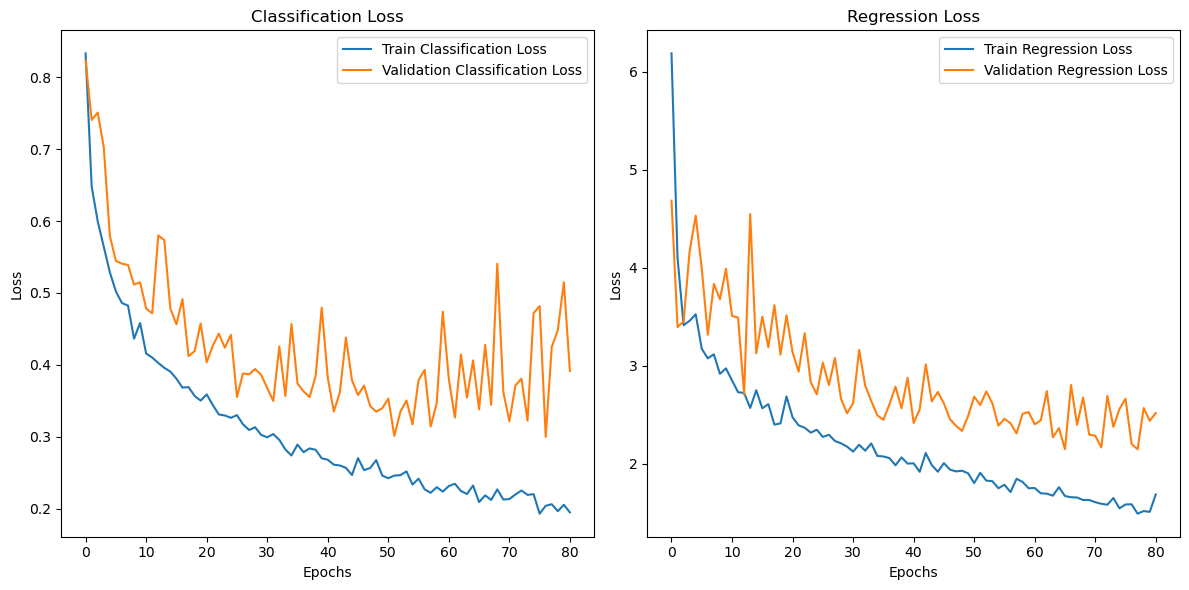

In [42]:
import matplotlib.pyplot as plt

# 'history'는 model.fit()의 반환값입니다.
# 분류 및 회귀 손실 데이터 추출
classification_loss = history.history['classification_loss']
regression_loss = history.history['regression_loss']
classification_val_loss = history.history['val_classification_loss']
regression_val_loss = history.history['val_regression_loss']

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 분류 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(classification_loss, label='Train Classification Loss')
plt.plot(classification_val_loss, label='Validation Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 회귀 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(regression_loss, label='Train Regression Loss')
plt.plot(regression_val_loss, label='Validation Regression Loss')
plt.title('Regression Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()